[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zhimingkuang/Harvard-AM-115/blob/main/11_diffusion/poisson.ipynb)

In [1]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
from matplotlib import path

### Python implementation of MATLAB's `numgrid` and `delsq`
reference: https://stackoverflow.com/questions/21097657/numpy-method-to-do-ndarray-to-vector-mapping-as-in-matlabs-delsq-demo


In [2]:
def numgrid(n):
    """
    NUMGRID Number the grid points in a two dimensional region.
    G = NUMGRID('R',n) numbers the points on an n-by-n grid in
    an L-shaped domain made from 3/4 of the entire square.
    adapted from C. Moler, 7-16-91, 12-22-93.
    Copyright (c) 1984-94 by The MathWorks, Inc.
    """
    x = np.ones((n,1)) * np.linspace(-1,1,n)
    y = np.flipud(x.T)
    # G = (x > -1) & (x < 1) & (y > -1) & (y < 1) & ( (x > 0) | (y > 0))
    G = ( x**2 + y**2 < 1) & ( x**2 + y**2 > 1/3);
    G = np.where(G,1,0) # boolean to integer
    k = np.where(G)
    G[k] = 1 + np.arange(len(k[0]))
    return G

def delsq(G):
    """
    DELSQ  Construct five-point finite difference Laplacian.
    delsq(G) is the sparse form of the two-dimensional,
    5-point discrete negative Laplacian on the grid G.
    adapted from  C. Moler, 7-16-91.
    Copyright (c) 1984-94 by The MathWorks, Inc.
    """
    [m,n] = G.shape
    # Indices of interior points
    G1 = G.flatten()
    p = np.where(G1)[0]
    N = len(p)
    # Connect interior points to themselves with 4's.
    i = G1[p]-1
    j = G1[p]-1
    s = 4*np.ones(p.shape)

    # for k = north, east, south, west
    for k in [-1, m, 1, -m]:
        # Possible neighbors in k-th direction
        Q = G1[p+k]
        # Index of points with interior neighbors
        q = np.where(Q)[0]
        # Connect interior points to neighbors with -1's.
        i = np.concatenate([i, G1[p[q]]-1])
        j = np.concatenate([j, Q[q]-1])
        s = np.concatenate([s, -np.ones(q.shape)])
    # sparse matrix with 5 diagonals
    return sparse.csr_matrix((s, (i,j)), (N,N))

### Solve a Poisson problem with boundary values set to zero
### Case 1: 1D Poisson

In [3]:
# A 1D Possion, i.e. an ODE 
m = 5 # size of the problem
e1 = np.ones(m) # build a vector of ones
A = spdiags(np.array([e1, -2*e1, e1]), [-1,0,1], m, m).A # build the Laplacian matrix with diagonals
f = np.ones(m)
u = np.linalg.solve(A, f)
print("Laplacian matrix A:\n", A)
print("Solution u:",u)

Laplacian matrix A:
 [[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]
Solution u: [-2.5 -4.  -4.5 -4.  -2.5]


In [4]:
# Problem with periodic boundary condition
A[0,-1] = 1 # periodic boundary condition
A[-1,0] = 1 # periodic boundary condition
u, _, _, _ = np.linalg.lstsq(A, f, rcond=None)
print("Laplacian matrix A:\n", A)
print("Solution u:",u)

Laplacian matrix A:
 [[-2.  1.  0.  0.  1.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 1.  0.  0.  1. -2.]]
Solution u: [ 7.46744666e-17  1.93646762e-16  2.37636120e-17 -2.29300282e-16
 -6.27845580e-17]


In [5]:
# Pin down the value at one point
A[-1,0] = 0
A[-1,-2] = 0
A[-1,-1] = 1
f[-1] = 0 # this sets u(m)=0
u, _,  _,_ = np.linalg.lstsq(A, f, rcond=None)
print("Laplacian matrix A:\n", A)
print("Solution u:",u)

Laplacian matrix A:
 [[-2.  1.  0.  0.  1.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  1.]]
Solution u: [-2.00000000e+00 -3.00000000e+00 -3.00000000e+00 -2.00000000e+00
 -1.14437961e-14]


### Case 2: 2D Poisson

In [6]:
# A 2D Poisson problem
m = 50 # size of the problem
# m = 5 # a smaller test problem

# Define the domain with a build-in Matlab function
# Note: Python implementation does not have 'S', 'L', 'A'
D = numgrid(2*m+1)

# Produce the Laplacian matrix (can be messy to generate yourself)
A = -delsq(D).A
# Source term, boundary values are set to zero
b = np.ones(A.shape[0])
# Solve
u = np.linalg.solve(A, b)
# Convert the vector to the domain shape
subs = np.argwhere(D>0) # points where the domain is defined
U = D.copy()
U[subs] = u[D[subs]-1]

In [7]:
# Customize for matplotlib
# If interested in the matplotlib object hierarchy, check: https://realpython.com/python-matplotlib-guide/
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['mathtext.default'] = 'regular'
# Change font size: http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20

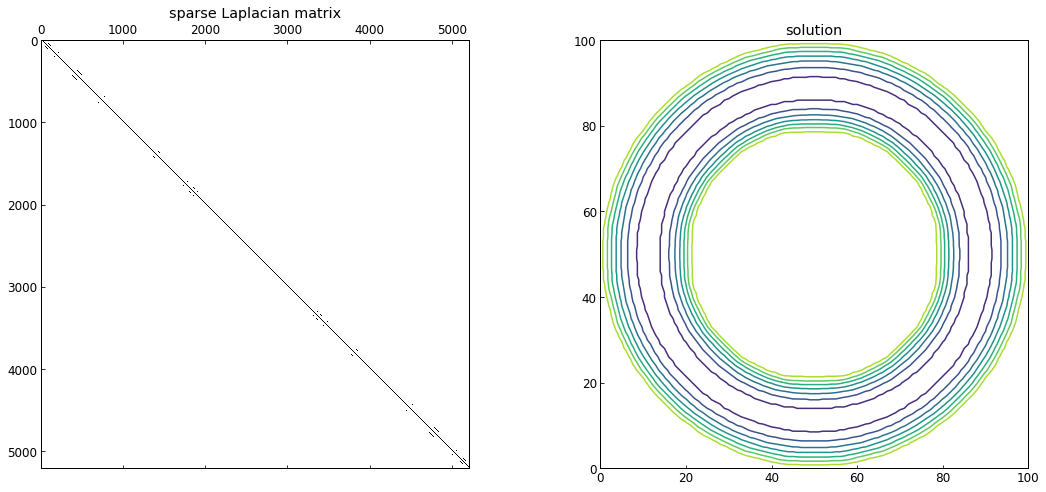

In [8]:
fig, axs = plt.subplots(1,2,figsize=(16,7))

# Visualize the sparsity of A
axs[0].spy(A)
# Plot the contour of results
axs[1].contour(U)
axs[1].set_aspect('equal')

# Set axes titles
axs[0].set_title('sparse Laplacian matrix')
axs[1].set_title('solution')

fig.tight_layout()
plt.show()

### Define your own domain
> Note: MATLAB uses a custom `inregion` function instead of calling library function `path.Path` to determine points inside or on a polygonal region

In [9]:
h = 0.2
x, y = np.meshgrid(np.arange(-1, 1+h, h), np.arange(-1, 1+h, h))
xv = [-0.5, -0.5, 0, 0, 1, 1, -1, -1, -0.5]
yv = [0, -0.5, -0.5, -1, -1, 1, 1, 0, 0]
inregion = path.Path(list(zip(xv, yv))).contains_points(list(zip(x.ravel(), y.ravel()))).reshape(x.shape)
p = np.argwhere(inregion.flatten())
n = len(p)
L = np.zeros(x.shape)
L[np.unravel_index(p, L.shape)] = np.arange(n).reshape(-1,1)

### Poisson solver with FFT for problems with periodic boundaries

In [10]:
# Size of the domain
Lx = 20
Ly = 20
# Number of grid points in each direction
nx = 128
ny = 128
# Construct the domain mesh
x2 = np.linspace(-Lx/2,Lx/2,nx+1)
x = x2[:nx] #x-values
y2 = np.linspace(-Ly/2,Ly/2,ny+1)
y = y2[:ny] #y-values
X, Y = np.meshgrid(x, y)

# The source term (right hand side of the Poisson equation)
omega = np.exp(-X**2 - Y**2) # generate 2D Gaussian
# Compute x and y wavenumbers
kx = (2*np.pi/Lx) * np.array([np.arange(nx/2), np.arange(-nx/2, 0)])
ky = (2*np.pi/Ly) * np.array([np.arange(ny/2), np.arange(-ny/2, 0)])

# Set the undetermined constant (zero wavenumber) to zero
kx[0,0] = 1.e-6
ky[0,0] = 1.e-6
KX, KY = np.meshgrid(kx,ky) # 2D wavenumbers

# Now solve the PDE in one line!
psi = np.real(np.fft.ifft2(-np.fft.fft2(omega) / (KX**2 + KY**2))) #solution

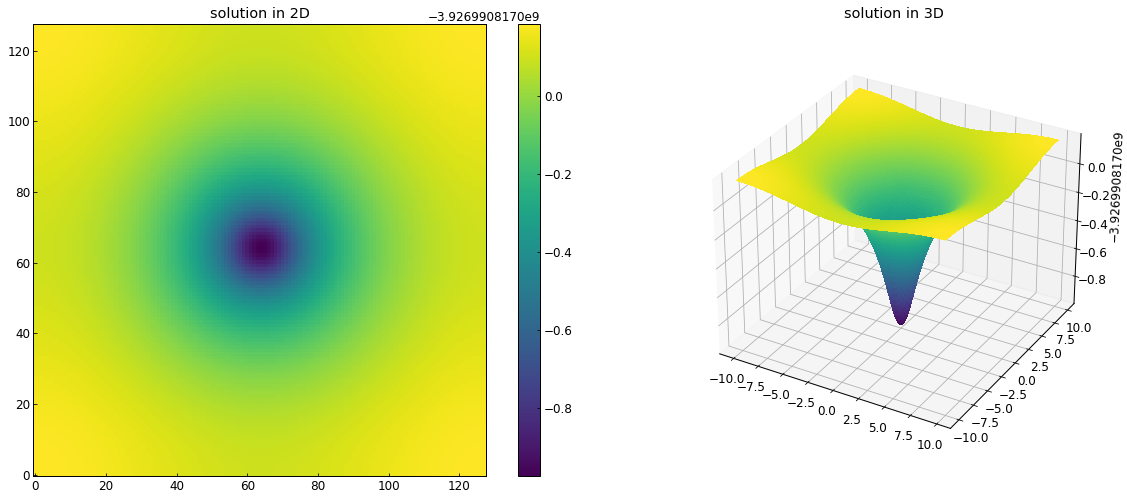

In [11]:
fig = plt.figure(figsize=(18,7)) # Set up a figure twice as wide as it is tall

# Visualize the solution in 2D
ax = fig.add_subplot(1, 2, 1)
img1 = ax.imshow(psi, origin='lower')
fig.colorbar(img1, ax=ax)
ax.set_title('solution in 2D')

# Visualize the solution in 3D
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, psi, rstride=1, cstride=1, cmap=plt.cm.viridis, linewidth=0.2, antialiased=False)
ax.dist = 11 # prevent axis labels from being cut off
ax.set_title('solution in 3D')

fig.tight_layout()
plt.show()